In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
# import numpy as np
from sklearn.ensemble import BaggingClassifier
import torch.nn as nn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import torch
import torch.optim as optim
import torch.nn as nn

In [2]:
filepath = 'data/titanic/train.csv'
train = pd.read_csv(filepath)
filepath = 'data/titanic/test.csv'
test = pd.read_csv(filepath)

In [3]:
train, val = train_test_split(train, test_size=0.2, random_state=42)

# Problem 1 - Classification Model 1:
---

After doing some initial analysis of the various input features and target label,
(show your work on this), run an experiment in Python using any of the techniques you learned about in lectures/materials/background reading. Clearly
show your code in your IPython notebook file (ultimately submitted as a pdf
file) along with the necessary comments showing the input features used in
your model and the hyperparameter settings (which depend on the model technique you are using). For example, if you’re using a random forest, one of
the hyperparameters would be the maximum tree depth, (there are many other
hyperparameter settings, as well).

• Pre-processing Techniques: Feature selection, feature creation, dimensionality reduction, noise reduction, attribute discretization, . . .

• Classification Techniques: decision trees for classification, rule-based classifiers, instance-based classifiers (including KNN’s), Bayesian classifiers,
artificial neural networks (ANN’s), support vector machines (SVM’s), and
finally, and perhaps most importantly, ensemble methods (bagging, boosting, random forests) for combining the methods listed above.

## Provide code/comments/appropriate description for the following:
---

### 1. Code and results for any preprocessing/visulization of input features and label (passenger survivorship).

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# print(f'There are {train.shape[0]} samples and {train.shape[1]} features in the training set.')
# print('------------------------------------')
# print('Results of train.info():')
# print(train.info())
# print('------------------------------------')
# print('Results of train.describe():')
# print(train.describe())

All of the feature datatypes seem to make sense. The 'Cabin' feature is 77% null so I will likely remove/transform that. The 'Age' feature is ~20% null so that will also need to be dealt with. 

General observations about the feature stats: The mean age is lower than I would have imagined. I'm also surprised that 'SibSp' stats were so low. I imagined that most people were on the Titanic with a spouse! The stats for the 'Parch' (number of parents or children aboard) feature are very low. From the little I know of the Titanic it didn't seem like something people would go on with their parents/kids, so this isn't particularly surprising. Still, I'm interested to see the details.

#### Dealing with Null Values

I'm taking different approaches to treating the nulls in 'Cabin' and 'Age'. Since 'Cabin' is mostly null I will just drop the column. 

In [4]:
train.drop('Cabin', axis=1, inplace=True)
val.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

For 'Age' I will fill the nulls. I'd rather fill them with group means than the col mean so I'll see if there is a good variable to group 'Age' by.

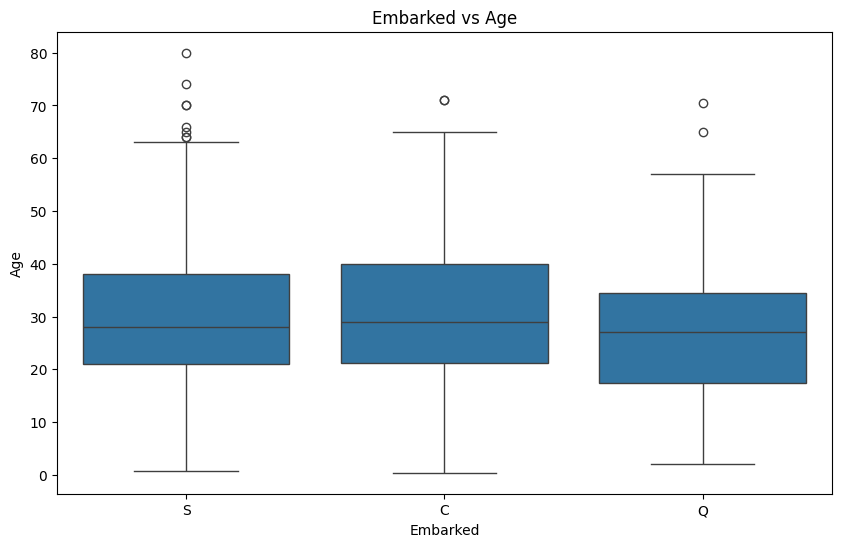

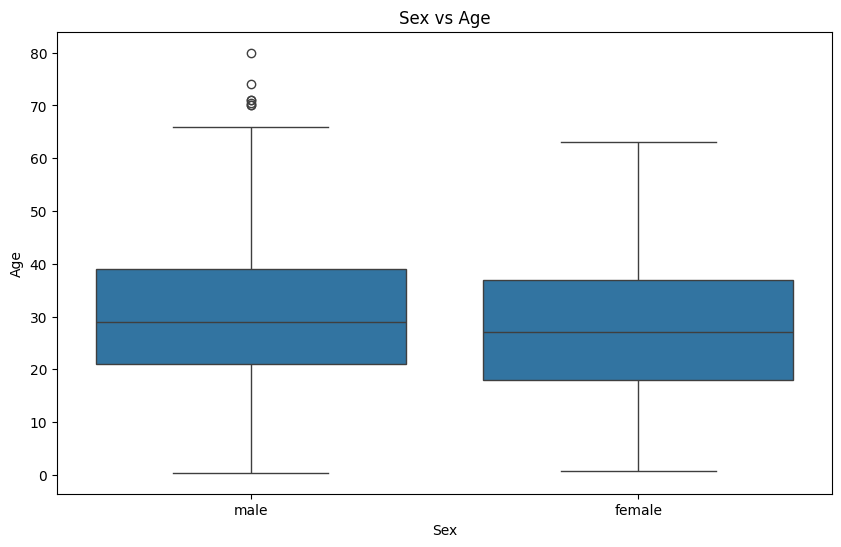

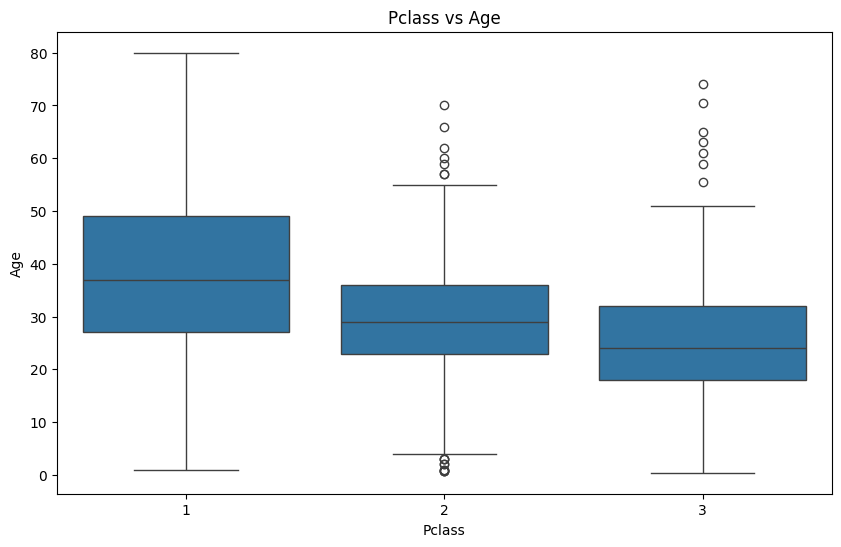

In [6]:
cols = ['Embarked', 'Sex', 'Pclass']
for col in cols:
    plt.figure(figsize=(10, 6))
    x= col
    y = 'Age'
    sns.boxplot(x=x, y=y, data=train)
    plt.title(f'{x} vs {y}')
    plt.show()

Based on this I think 'Pclass' makes sense as a grouping variable for 'Age'.

In [5]:
train['Age'] = train.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.mean()))
val['Age'] = val.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.mean()))
test['Age'] = test.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.mean()))

#### EDA Continued

In [8]:
value_counts = train['Parch'].value_counts()
for i in range(len(value_counts)):
    print(f'{value_counts.iloc[i]} passengers had {value_counts.index[i]} parents or children aboard.')

678 passengers had 0 parents or children aboard.
118 passengers had 1 parents or children aboard.
80 passengers had 2 parents or children aboard.
5 passengers had 5 parents or children aboard.
5 passengers had 3 parents or children aboard.
4 passengers had 4 parents or children aboard.
1 passengers had 6 parents or children aboard.


Plotting first the numerical then the categorical features for more details on what we saw in .describe().

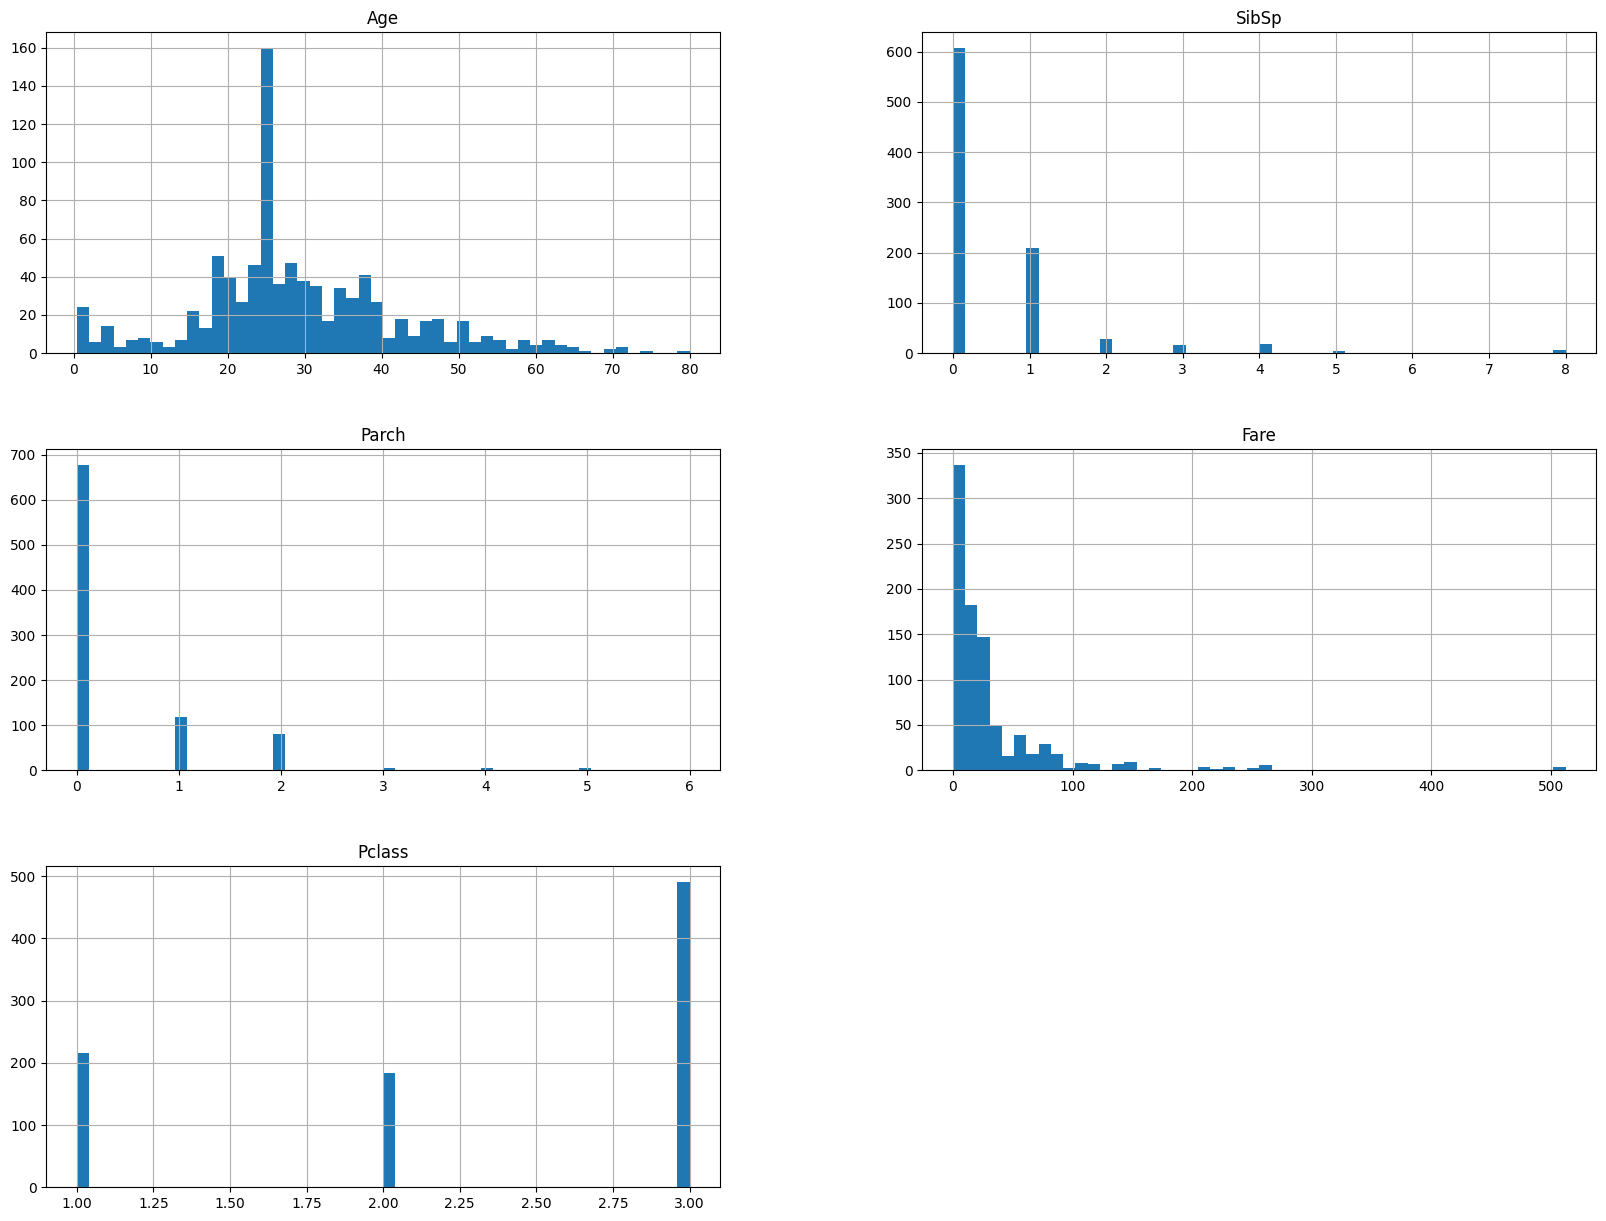

In [9]:
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']
train[numerical_features].hist(bins=50, figsize=(20, 15))
plt.show()

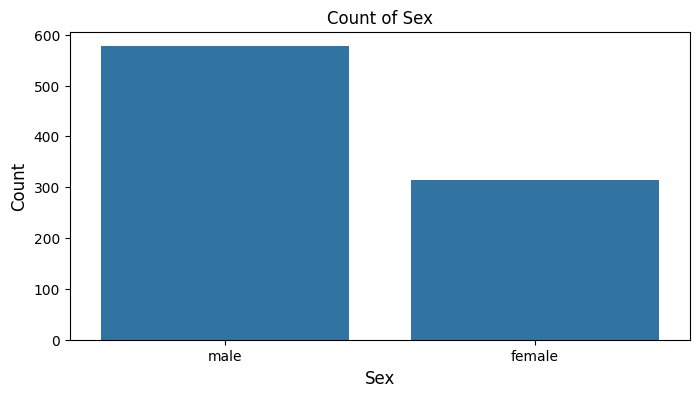

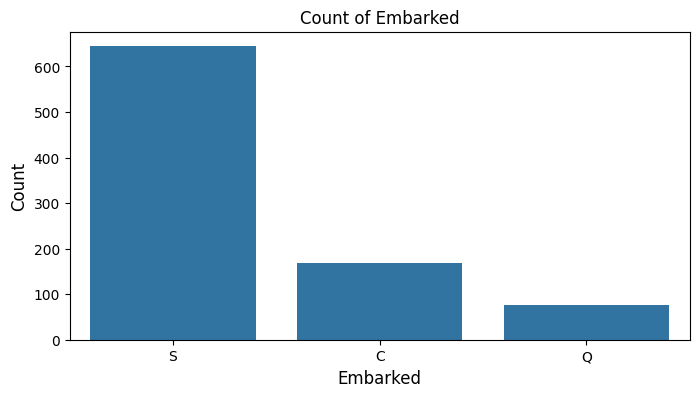

In [10]:
categorical_features = ['Sex', 'Embarked']

for col in train[categorical_features].columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=train)
    plt.title(f'Count of {col}')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.show()

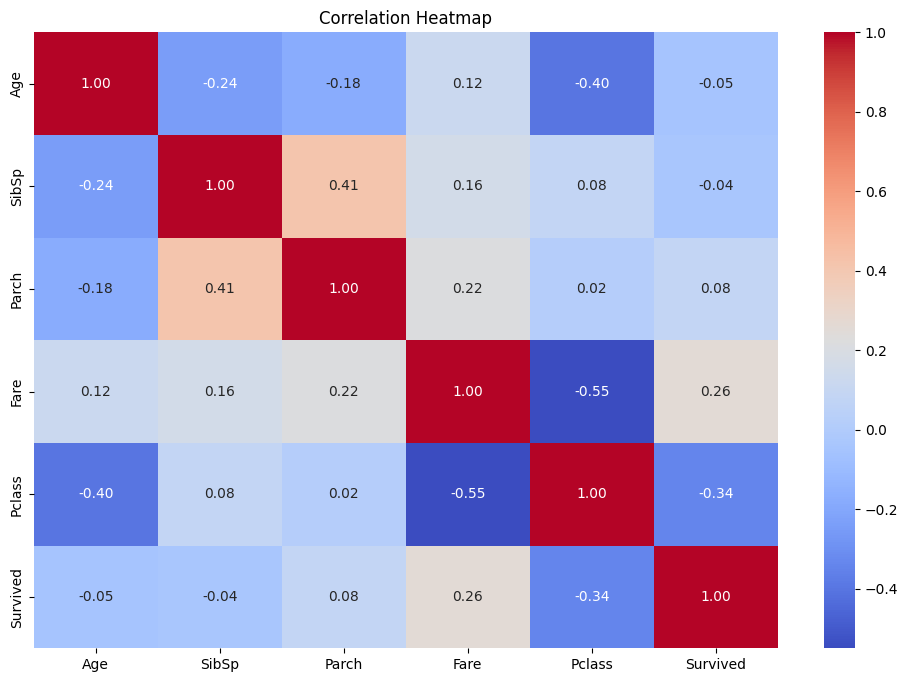

In [11]:
corr_features = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'Survived',]
plt.figure(figsize=(12, 8))
sns.heatmap(train[corr_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

We can see that 'Fare' and 'Pclass' have a negative correlation. Might be worth combining those into one feature.

In [97]:
mean_age_survived = train.groupby('Survived')['Age'].median()
print(mean_age_survived)

Survived
0    25.162917
1    27.000000
Name: Age, dtype: float64


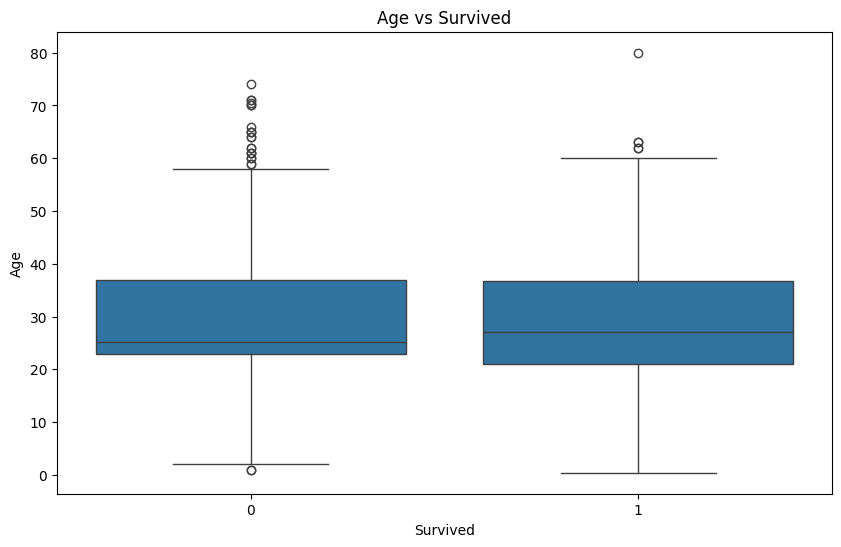

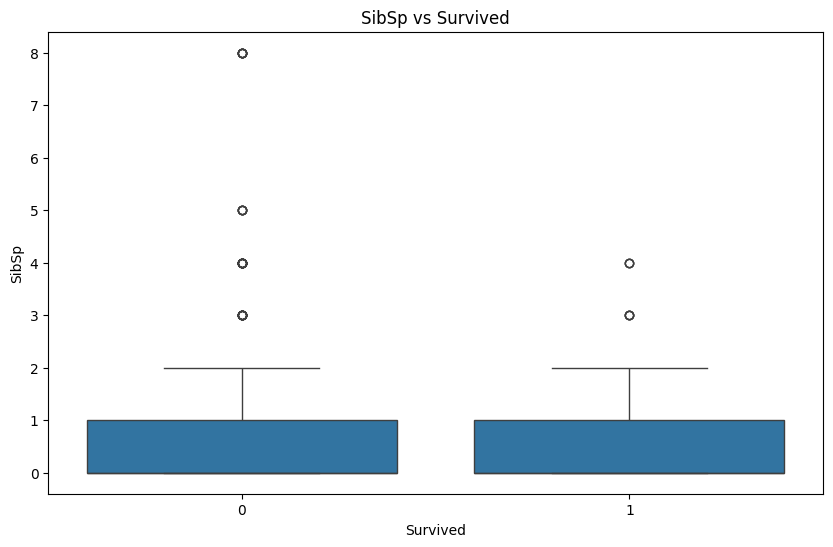

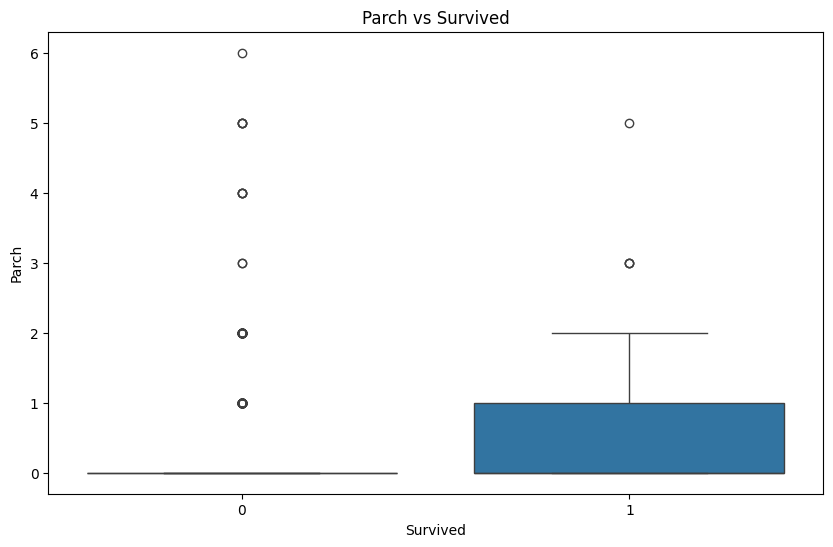

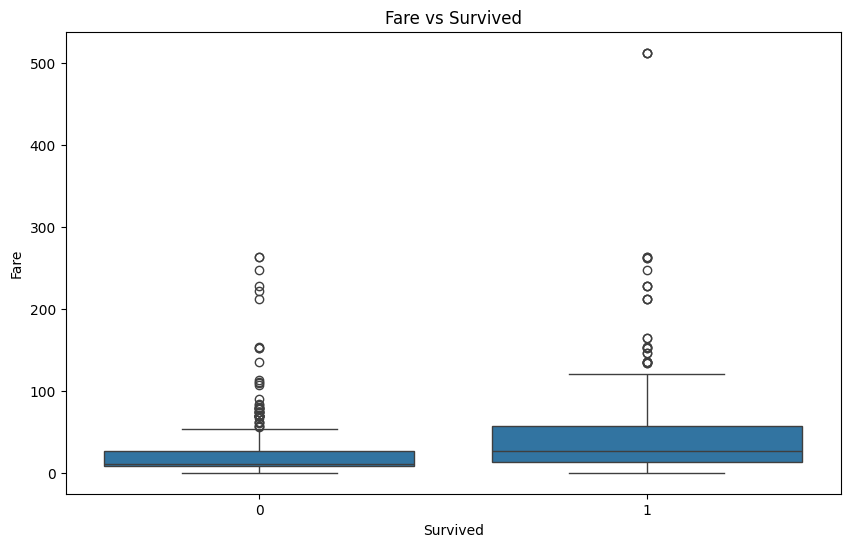

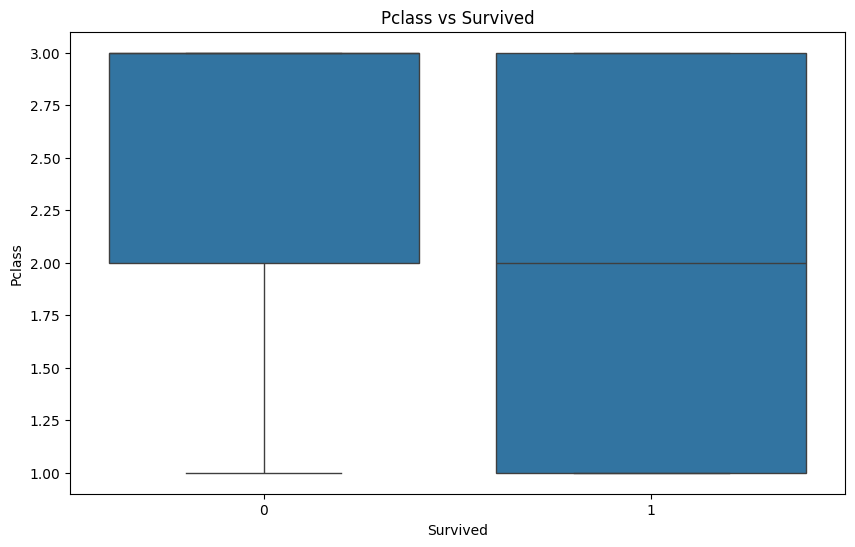

In [12]:
for column in train[corr_features].columns:
    if column != 'Survived':
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Survived', y=column, data=train)
        plt.title(f'{column} vs Survived')
        plt.show()

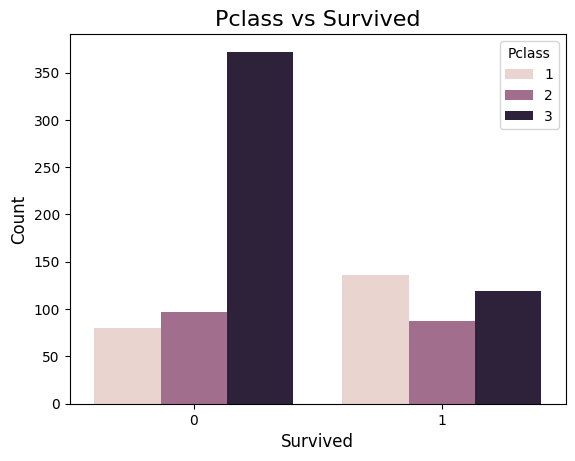

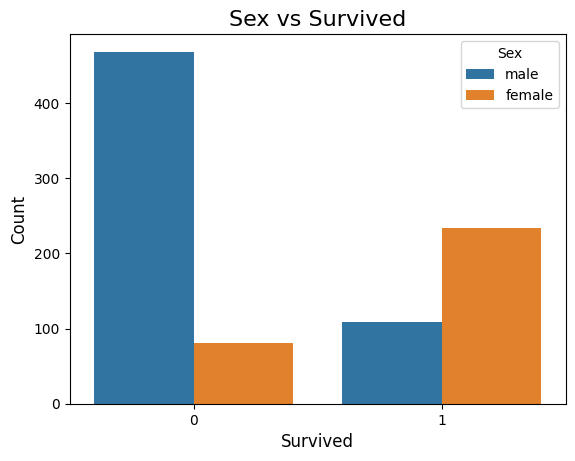

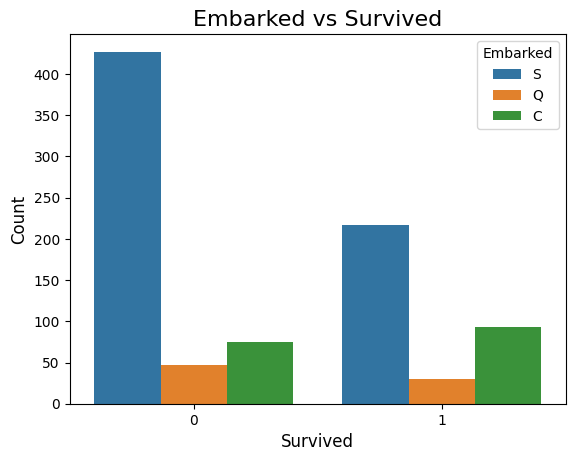

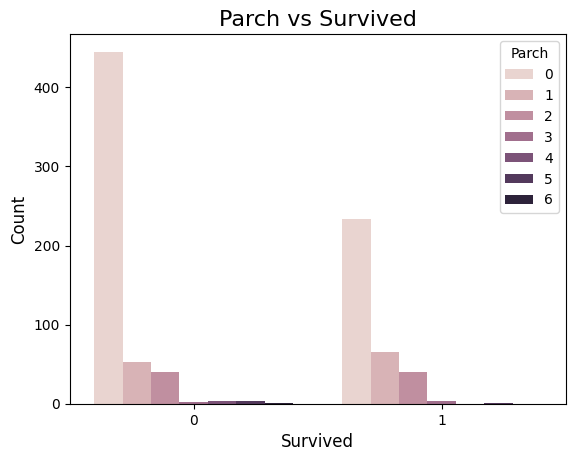

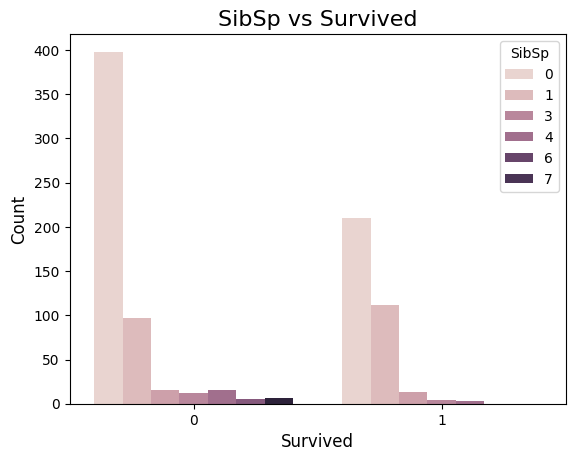

In [13]:
cat_features = ['Pclass', 'Sex', 'Embarked', 'Parch', 'SibSp']
for col in cat_features:
    sns.countplot(x='Survived', hue=col, data=train)
    plt.title(f'{col} vs Survived', fontsize=16)
    plt.xlabel('Survived', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title=col)
    plt.show()

In [14]:
cat_features = ['Pclass', 'Sex', 'Embarked', 'Parch', 'SibSp']#, 'Parch_binary']

for col in cat_features:
    contingency_table = pd.crosstab(train[col], train['Survived'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    if p < 0.05:
        print(f'Chi-squared test for {col} vs Survived:')
        print(f"Chi-squared Statistic: {chi2}")
        print(f"P-value: {p}")
        print(f"Degrees of Freedom: {dof}")
        print(f"Expected Frequencies: \n{expected}")
        print('------------------------------------')
    else:
        print(f'{col} is not associated with Survived.')




Chi-squared test for Pclass vs Survived:
Chi-squared Statistic: 102.88898875696056
P-value: 4.549251711298793e-23
Degrees of Freedom: 2
Expected Frequencies: 
[[133.09090909  82.90909091]
 [113.37373737  70.62626263]
 [302.53535354 188.46464646]]
------------------------------------
Chi-squared test for Sex vs Survived:
Chi-squared Statistic: 260.71702016732104
P-value: 1.1973570627755645e-58
Degrees of Freedom: 1
Expected Frequencies: 
[[193.47474747 120.52525253]
 [355.52525253 221.47474747]]
------------------------------------
Chi-squared test for Embarked vs Survived:
Chi-squared Statistic: 26.48914983923762
P-value: 1.769922284120912e-06
Degrees of Freedom: 2
Expected Frequencies: 
[[103.7480315  64.2519685]
 [ 47.5511811  29.4488189]
 [397.7007874 246.2992126]]
------------------------------------
Chi-squared test for Parch vs Survived:
Chi-squared Statistic: 27.925784060236168
P-value: 9.703526421039996e-05
Degrees of Freedom: 6
Expected Frequencies: 
[[4.17757576e+02 2.6024242

In [ ]:
# train['Female'] = (train['Sex'] == 'female').astype(int)
# val['Female'] = (val['Sex'] == 'female').astype(int)
# test['Female'] = (test['Sex'] == 'female').astype(int)

In [16]:
numerical_features = ['Age', 'SibSp', 'Fare', 'Pclass', 'Parch', 'Female']# 'Parch_binary']#, 'Parch']

scaler = StandardScaler()
scaled = scaler.fit_transform(train[numerical_features])

pca = PCA(n_components=2) 
pca.fit(scaled)

components = pca.components_

loadings = pd.DataFrame(components, columns=numerical_features)

importance = loadings.iloc[0].abs()  
importance = importance.sort_values(ascending=False)

print("\nFeature Importance for the First Principal Component:")
print(importance)


Feature Importance for the First Principal Component:
Fare      0.615065
Pclass    0.534100
Female    0.351838
Parch     0.349243
SibSp     0.244704
Age       0.175473
Name: 0, dtype: float64


We can see something really interesting for 'Parch' when we compare the heatmap to the boxplots: while the heatmap shows low correlation between 'Parch' and the target variable, the box plot seems to suggest a relationship. 

In [17]:
n_survived = train[train['Survived'] == 1].shape[0]
n_not_survived = train[train['Survived'] == 0].shape[0]
print(f'{round(n_survived / train.shape[0] * 100)}% of passengers survived.')

38% of passengers survived.


In [18]:
break_feature = 'Survived'
break_two_feature = 'Parch'
subset = train[train[break_feature] == 1]
n = subset.shape[0]

# for class_num in [1,]:
num_class_total = train[train[break_two_feature] == 0].shape[0]
pct_of_total = num_class_total/train.shape[0]
num_class_subset = subset[subset[break_two_feature] == 0].shape[0]
pct_class = num_class_subset/n
pct_of_class = num_class_subset/num_class_total
print(f'{round(pct_of_total*100)}% of passengers did not have parents or children on board.')
print(f'{round(pct_class*100)}% of surviving passengers did not have parents or children on board.')
print(f'{round(pct_of_class*100)}% of passengers who did not have parents or children on board survived.')
print('------------------------------------')

num_class_total = train[train[break_two_feature] > 0].shape[0]
pct_of_total = num_class_total/train.shape[0]
num_class_subset = subset[subset[break_two_feature] > 0].shape[0]
pct_class = num_class_subset/n
pct_of_class = num_class_subset/num_class_total
print(f'{round(pct_of_total*100)}% of passengers had parents or children on board.')
print(f'{round(pct_class*100)}% of surviving passengers had parents or children on board.')
print(f'{round(pct_of_class*100)}% of passengers who had parents or children on board survived.')
print('------------------------------------')

num_class_total = train[train[break_two_feature] > 1].shape[0]
pct_of_total = num_class_total/train.shape[0]
num_class_subset = subset[subset[break_two_feature] > 1].shape[0]
pct_class = num_class_subset/n
pct_of_class = num_class_subset/num_class_total
print(f'{round(pct_of_total*100)}% of passengers had more than one parents or children on board.')
print(f'{round(pct_class*100)}% of surviving passengers had more than one parents or children on board.')
print(f'{round(pct_of_class*100)}% of passengers who had more than one parents or children on board survived.')
print('------------------------------------')

for class_num in range(1,7):
    num_class_total = train[train[break_two_feature] == class_num].shape[0]
    pct_of_total = num_class_total/train.shape[0]
    num_class_subset = subset[subset[break_two_feature] == class_num].shape[0]
    pct_class = num_class_subset/n
    pct_of_class = num_class_subset/num_class_total
    print(f'{round(pct_of_total*100)}% of passengers had {class_num} parents or children on board.')
    print(f'{round(pct_class*100)}% of surviving passengers had {class_num} parents or children on board.')
    print(f'{round(pct_of_class*100)}% of passengers who had {class_num} parents or children on board survived.')
    print('------------------------------------')

76% of passengers did not have parents or children on board.
68% of surviving passengers did not have parents or children on board.
34% of passengers who did not have parents or children on board survived.
------------------------------------
24% of passengers had parents or children on board.
32% of surviving passengers had parents or children on board.
51% of passengers who had parents or children on board survived.
------------------------------------
11% of passengers had more than one parents or children on board.
13% of surviving passengers had more than one parents or children on board.
46% of passengers who had more than one parents or children on board survived.
------------------------------------
13% of passengers had 1 parents or children on board.
19% of surviving passengers had 1 parents or children on board.
55% of passengers who had 1 parents or children on board survived.
------------------------------------
9% of passengers had 2 parents or children on board.
12% of s

Since survival rate was about the same for passengers who 1 to 3 parents or children on board (and very very few passengers had more than three parents or children on board), I think it makes sense to make 'Parch' into a binary [0='did not have children or parents', 1='had children or parents'] variable. 

In [6]:
train['Parch_binary'] = (train['Parch'] > 0).astype(int)
val['Parch_binary'] = (val['Parch'] > 0).astype(int)
test['Parch_binary'] = (test['Parch'] > 0).astype(int)

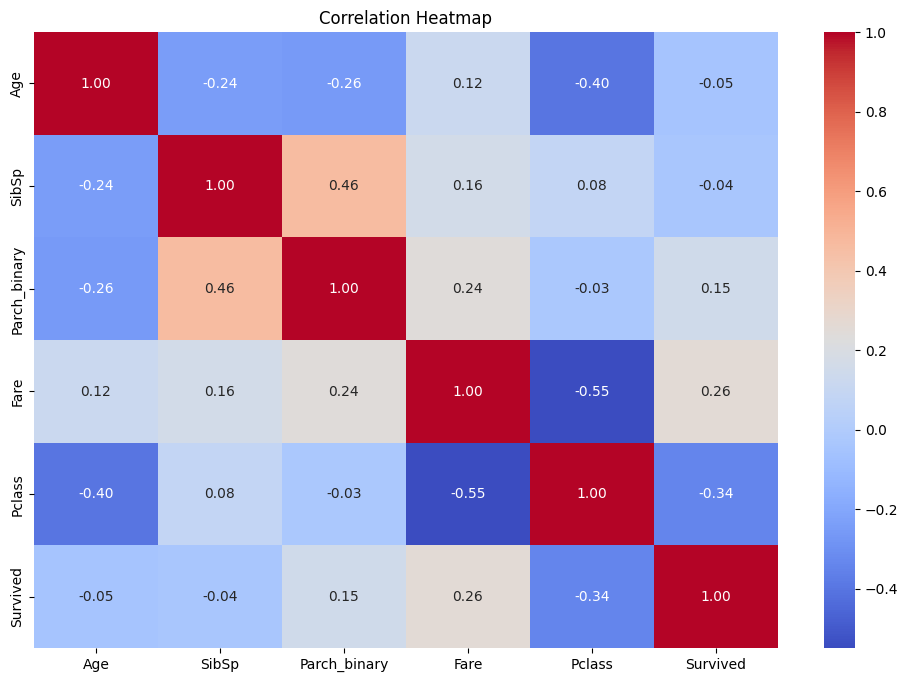

In [20]:
corr_features = ['Age', 'SibSp', 'Parch_binary', 'Fare', 'Pclass', 'Survived']
plt.figure(figsize=(12, 8))
sns.heatmap(train[corr_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [21]:
break_feature = 'Survived'
break_two_feature = 'Pclass'
subset = train[train[break_feature] == 1]
n = subset.shape[0]

for class_num in range(1,4):
    num_class_total = train[train[break_two_feature] == class_num].shape[0]
    pct_of_total = num_class_total/train.shape[0]
    num_class_subset = subset[subset[break_two_feature] == class_num].shape[0]
    pct_class = num_class_subset/n
    pct_of_class = num_class_subset/num_class_total
    print(f'{round(pct_of_total*100)}% of passengers had class {class_num} tickets.')
    print(f'{round(pct_class*100)}% of surviving passengers had class {class_num} tickets.')
    print(f'{round(pct_of_class*100)}% of passengers with class {class_num} tickets survived.')
    print('------------------------------------')

24% of passengers had class 1 tickets.
40% of surviving passengers had class 1 tickets.
63% of passengers with class 1 tickets survived.
------------------------------------
21% of passengers had class 2 tickets.
25% of surviving passengers had class 2 tickets.
47% of passengers with class 2 tickets survived.
------------------------------------
55% of passengers had class 3 tickets.
35% of surviving passengers had class 3 tickets.
24% of passengers with class 3 tickets survived.
------------------------------------


In [7]:
train['Pclass_binary'] = (train['Pclass'] != 3).astype(int)
val['Pclass_binary'] = (val['Pclass'] != 3).astype(int)
test['Pclass_binary'] = (test['Pclass'] != 3).astype(int)

In [170]:
train.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Parch_binary,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Sex_male
331,332,0,"Partner, Mr. Austen",45.5,0,0,113043,28.5000,0,False,True,False,False,True
733,734,0,"Berriman, Mr. William John",23.0,0,0,28425,13.0000,0,False,True,True,False,True
382,383,0,"Tikkanen, Mr. Juho",32.0,0,0,STON/O 2. 3101293,7.9250,0,False,True,False,True,True
704,705,0,"Hansen, Mr. Henrik Juul",26.0,1,0,350025,7.8542,0,False,True,False,True,True
813,814,0,"Andersson, Miss. Ebba Iris Alfrida",6.0,4,2,347082,31.2750,1,False,True,False,True,False


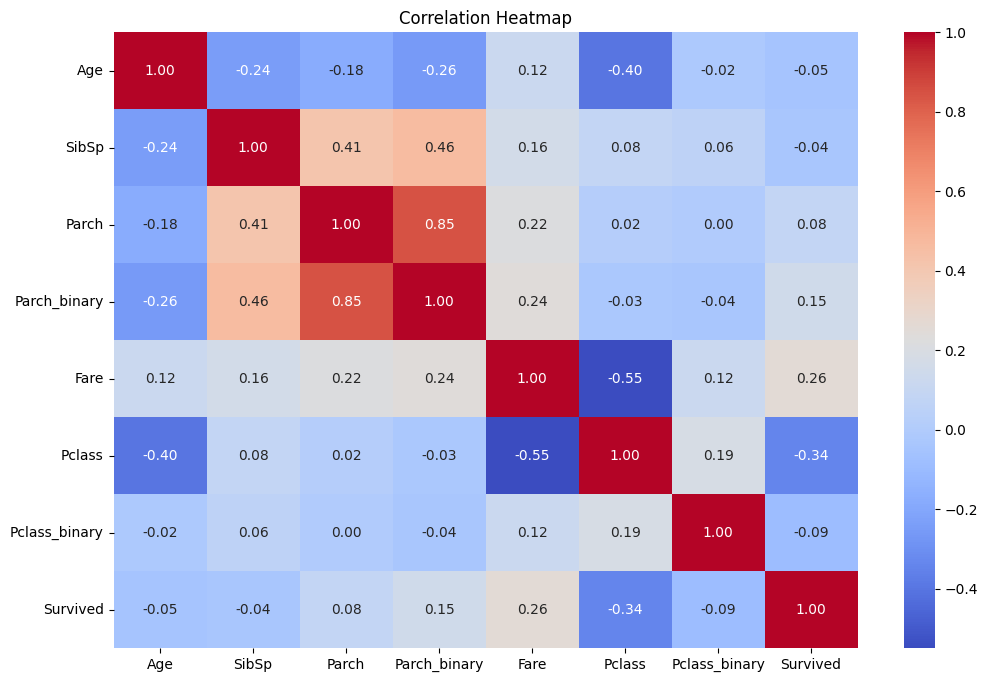

In [23]:
corr_features = ['Age', 'SibSp', 'Parch', 'Parch_binary', 'Fare', 'Pclass', 'Pclass_binary', 'Survived']
plt.figure(figsize=(12, 8))
sns.heatmap(train[corr_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Since several of the features have minimal correlation with the target variable it might make sense to do PCA.

### 2. Code and results for the model, including performance/accuracy on the training set and on your validation set.

In [8]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Parch_binary,Pclass_binary
331,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,S,0,1
733,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,S,0,1
382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,S,0,0
704,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,S,0,0
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,S,1,0


In [10]:
train['Fare_binary'] = (train['Fare'] > 10).astype(int)
val['Fare_binary'] = (val['Fare'] > 10).astype(int)
test['Fare_binary'] = (test['Fare'] > 10).astype(int)

In [8]:
train = pd.get_dummies(train, columns=['Embarked'], drop_first=True)
val = pd.get_dummies(val, columns=['Embarked'], drop_first=True)
test = pd.get_dummies(test, columns=['Embarked'], drop_first=True)

train = pd.get_dummies(train, columns=['Pclass'], drop_first=True)
val = pd.get_dummies(val, columns=['Pclass'], drop_first=True)
test = pd.get_dummies(test, columns=['Pclass'], drop_first=True)

train = pd.get_dummies(train, columns=['Sex'], drop_first=True)
val = pd.get_dummies(val, columns=['Sex'], drop_first=True)
test = pd.get_dummies(test, columns=['Sex'], drop_first=True)
train.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Parch_binary,Pclass_binary,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Sex_male
331,332,0,"Partner, Mr. Austen",45.5,0,0,113043,28.5000,0,1,False,True,False,False,True
733,734,0,"Berriman, Mr. William John",23.0,0,0,28425,13.0000,0,1,False,True,True,False,True
382,383,0,"Tikkanen, Mr. Juho",32.0,0,0,STON/O 2. 3101293,7.9250,0,0,False,True,False,True,True
704,705,0,"Hansen, Mr. Henrik Juul",26.0,1,0,350025,7.8542,0,0,False,True,False,True,True
813,814,0,"Andersson, Miss. Ebba Iris Alfrida",6.0,4,2,347082,31.2750,1,0,False,True,False,True,False


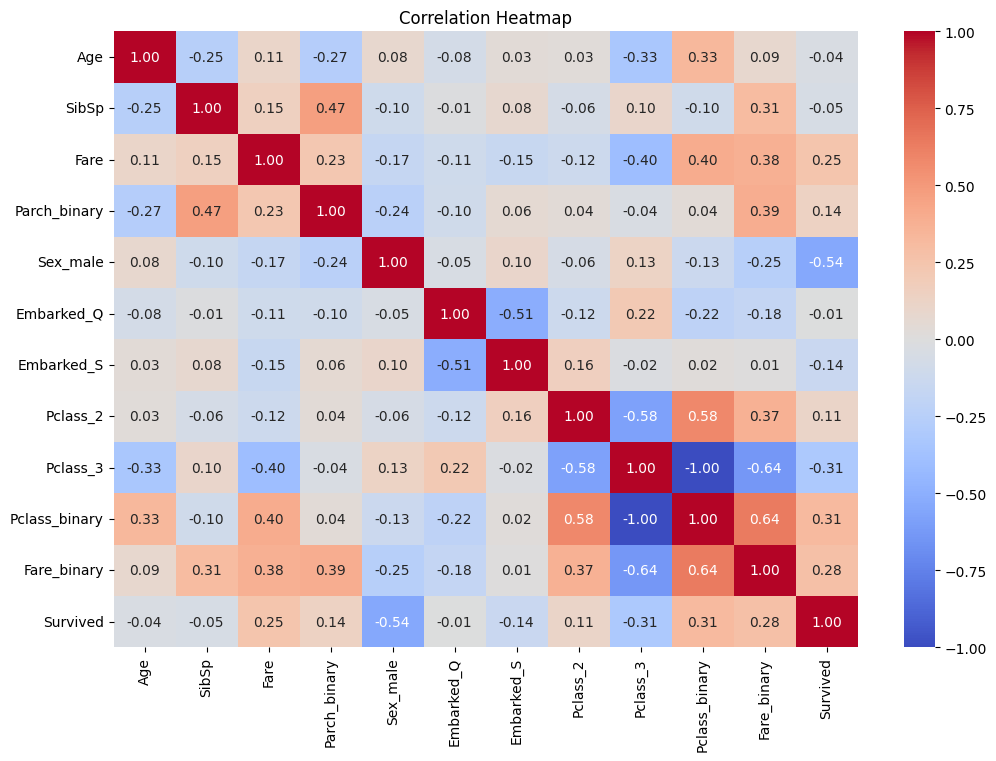

In [52]:
corr_features = ['Age', 'SibSp', 'Fare', 'Parch_binary', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Pclass_2', 'Pclass_3', 'Pclass_binary', 'Fare_binary', 'Survived']
plt.figure(figsize=(12, 8))
sns.heatmap(train[corr_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [11]:
# X_train = train[['Age', 'SibSp', 'Fare', 'Parch_binary', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Pclass_2', 'Pclass_3', 'Pclass_binary',]]
X_train = train[['Age', 'SibSp','Fare_binary', 'Parch_binary', 'Sex_male', 'Embarked_Q', 'Embarked_S','Pclass_2', 'Pclass_binary',]]
y_train = train['Survived']

# X_val = val[['Age', 'SibSp', 'Fare', 'Parch_binary', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Pclass_2', 'Pclass_3', 'Pclass_binary',]]
X_val = val[['Age', 'SibSp',  'Fare_binary', 'Parch_binary', 'Sex_male', 'Embarked_Q', 'Embarked_S','Pclass_2','Pclass_binary',]]
y_val = val['Survived']

# X_test = test[['Age', 'SibSp', 'Fare', 'Parch_binary', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Pclass_2', 'Pclass_3', 'Pclass_binary',]]
X_test = test[['Age', 'SibSp', 'Fare_binary', 'Parch_binary', 'Sex_male', 'Embarked_Q', 'Embarked_S','Pclass_2','Pclass_binary',]]

In [20]:
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train, y_train)
print(f'Training Accuracy: {rf.score(X_train, y_train)*100:.2f}%')

print(f'Validation Accuracy: {rf.score(X_val, y_val)*100:.2f}%')

Training Accuracy: 93.40%
Validation Accuracy: 81.01%


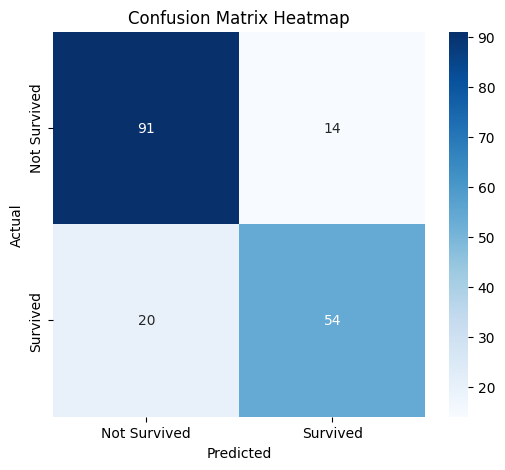

In [21]:
from sklearn.metrics import confusion_matrix
# import numpy as np

y_pred = rf.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()


In [ ]:
test_preds = pd.DataFrame()
test_preds['PassengerId'] = test['PassengerId']
test_preds['Survived'] = rf.predict(X_test)
test_preds.to_csv('data/titanic/rf_test_preds.csv', index=False)

### 3. A snapshot of the submission including your team name (as an individual, you’re a team of 1 person), as shown on the Kaggle leaderboard.

As a note, I changed my last name a couple years ago so my name still shows up in some locations (such as Kaggle) as Cate Merfeld even though my name at WPI has been updated to Cate Dunham.

![Screenshot 2025-03-17 122343.png](<attachment:Screenshot 2025-03-17 122343.png>)
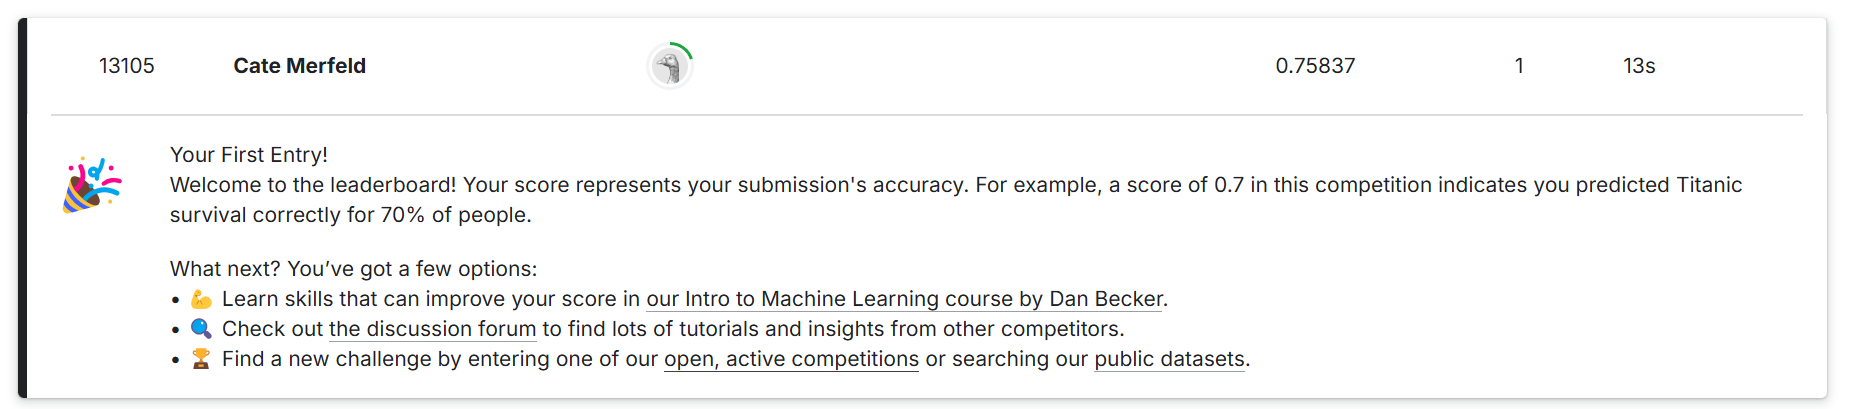

### 4. Commentary on the relative performance of your model, relative to that of other teams. It is not necessary to have a high performing model at this point, but you should have some idea about next steps for improving the model.

My first submission was number 13,105 out of 15,341 total entries, meaning it was in the bottom 24% of entries and the bottom 24% of entries with test accuracy higher than random guess (50% for two classes)

# Problem 2 - Classification Model 2:
---
Repeat Problem 1, but this time with a different model. It is sufficient to try
the same technique but with different hyperparameter values. However, you will
need to provide comments about the relative performance of your new model
compared to your Classification Model 1. Provide all of the information as listed
for Classification Model 1 (code, results, performance, etc.).

In [ ]:
max_depths = [7, 8, 9, 10]
n_estimators = [25, 50, 100, 200]

best_val_accuracy = 0
best_depth = None
best_estimators = None

for depth in max_depths:
    for n in n_estimators:
        base_model = DecisionTreeClassifier(max_depth=depth)

        # Initialize and train BaggingClassifier
        bagging_model = BaggingClassifier(estimator=base_model, n_estimators=n, random_state=42)
        bagging_model.fit(X_train, y_train)

        print(f'Results for Bagging Classifier with Base Model Max Depth of {depth} and {n} Estimators:')

        # Print training accuracy
        print(f'        Training Accuracy: {bagging_model.score(X_train, y_train) * 100:.2f}%')

        # Make predictions on validation set
        bagging_predictions = bagging_model.predict(X_val)

        val_accuracy = bagging_model.score(X_val, y_val)
        # Print validation accuracy
        print(f'        Validation Accuracy: {val_accuracy * 100:.8f}%')

        if val_accuracy > best_val_accuracy:
            print(f'        New best validation accuracy: {val_accuracy * 100:.8f}%')
            best_depth = depth
            best_estimators = n
            best_val_accuracy = val_accuracy
        print('------------------------------------')

print(f'Best Validation Accuracy: {best_val_accuracy * 100:.8f}%')
print(f'Best Max Depth: {best_depth}')
print(f'Best Number of Estimators: {best_estimators}')

Results for Bagging Classifier with Base Model Max Depth of 7 and 25 Estimators:
        Training Accuracy: 88.20%
        Validation Accuracy: 79.88826816%
        New best validation accuracy: 79.88826816%
------------------------------------
Results for Bagging Classifier with Base Model Max Depth of 7 and 50 Estimators:
        Training Accuracy: 88.34%
        Validation Accuracy: 79.88826816%
------------------------------------
Results for Bagging Classifier with Base Model Max Depth of 7 and 100 Estimators:
        Training Accuracy: 89.04%
        Validation Accuracy: 77.65363128%
------------------------------------
Results for Bagging Classifier with Base Model Max Depth of 7 and 200 Estimators:
        Training Accuracy: 88.34%
        Validation Accuracy: 78.77094972%
------------------------------------
Results for Bagging Classifier with Base Model Max Depth of 8 and 25 Estimators:
        Training Accuracy: 90.45%
        Validation Accuracy: 79.88826816%
--------------

In [ ]:
base_model = DecisionTreeClassifier(max_depth=best_depth)

# Initialize and train BaggingClassifier
bagging_model = BaggingClassifier(estimator=base_model, n_estimators=best_estimators, random_state=42)
bagging_model.fit(X_train, y_train)


model_name = 'BaggingClassifier'
test_predictions = pd.DataFrame()
test_predictions['PassengerId'] = test['PassengerId']
test_predictions['Survived'] = bagging_model.predict(X_test)
test_predictions.to_csv(f'data/titanic/{model_name}_test_predictions.csv', index=False)

With a test accuracy of ~78%, my model was in the top 24% of entries. It was also in the top 24% of entries with test accuracy higher than random guess.

![Screenshot 2025-03-17 130337.png](<attachment:Screenshot 2025-03-17 130337.png>)
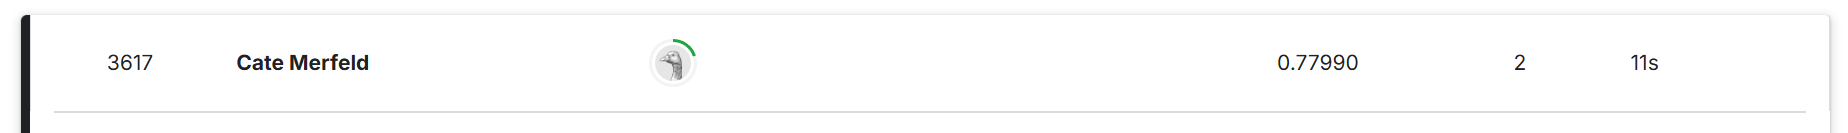

# Problem 3 - Classification Model 3:
---

Repeat Problem 1 yet again, but this time with a different model from either
Problem 1 or 2. You should be looking not for perfection, but for improvement
in accuracy on your validation set, and ultimately on your position on the
leaderboard (although this is not absolutely necessary). If you find the accuracy
going down, you should comment as to possible reasons why. Submit all code,
results, comments on relative performance as you did in Problem 2.

Try making family size feature 

# Compiling Each Model’s Results for the Assignment:
---
Each student will submit a pdf document that shows their code, output, comments, visualizations etc.. This will be accomplished by building a IPython/Jupyter notebook to complete the assignment and then after completion, converting the document to pdf format.

As part of this assignment you will not only download the titanic dataset but
you’ll also join the competition (by clicking on the ”Join the Competition”
button on the Kaggle/Titanic webpage).

For each model, you’ll use the training dataset to train a model, but also estimate the accuracy of your model. You’ll accomplish this by splitting the training
set (in the training file downloaded from Kaggle) into two subsets - an actual
training set on which you’ll train the model, and then a validation set (say, an
80/20 split, but that’s just a suggestion) on which you’ll run the trained model
to see how accurate it is. You’ll be able to get an accurate performance reading
as you’ll know what the actual results are for these records (they were part of
the original training set you downloaded).

Next, you’ll run your model on the actual test set data file you downloaded
from Kaggle. The label values (whether the passenger survived, 1 or 0), for
the records in the test file are not given. So, you are not able to determine the
accuracy of your model against the test set by simply running your model on
these records. Instead, you’ll submit the test file with your model’s predictions
for these passengers to Kaggle, where the platform will compare your model’s
predicted values with the acutal, (hidden) values to give you an accuracy score.
Note, you won’t be given the correct/incorrect breakdown of the individual test
records for your model - you’ll only see the overall accuracy score. It will be left
to you to take this coarse-grained accuracy info and think of ways to improve
your model.

After the Kaggle platform determines your model’s accuracy, it will post your
”team” name (since you’re each doing this individually, you each constitute a
team of 1, and you can name your team however you like), along with your
accuracy at the appropriate position on the leaderboard. Take a screenshot of
your team position on the leaderboard and include it for each of the 3 models
you develop as part of the assignment.

Figures 1, 2 and 3, below, show images of the Kaggle leaderboard, including
individual entrants, the number of submissions they’ve made, and the accuracy
of their last submission on the Kaggle test set.

Please understand I am not looking for you to have a 100% accuracy for any
of your models. The important aspect is after starting with a simple model,
you start thinking about ways to improve the model, record your reasoning
for making these changes, determining whether the model has improved after
submitting against the Kaggle test set, and providing further reasoning about
any change to performance (positive or negative).

# Unused Code:
---

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

rf = RandomForestClassifier(n_estimators=20, random_state=42)#, max_depth=5)
rf.fit(X_train_scaled, y_train)
print(f'Training Accuracy: {rf.score(X_train_scaled, y_train)*100:.2f}%')

# rf.predict(X_val_scaled)
print(f'Validation Accuracy: {rf.score(X_val_scaled, y_val)*100:.2f}%')

Training Accuracy: 94.24%
Validation Accuracy: 81.56%


In [ ]:
pca = PCA(n_components=7)
pca.fit(X_train_scaled)
X_train_transformed = pca.transform(X_train_scaled)
X_val_transformed = pca.transform(X_val_scaled)

rf = RandomForestClassifier(n_estimators=100, random_state=42)#, max_depth=500)
rf.fit(X_train_transformed, y_train)
# train_preds = rf.predict(X_train_transformed)
print(f'Training Accuracy: {rf.score(X_train_transformed, y_train)*100:.2f}%')
# val_preds = rf.predict(X_val_transformed)
print(f'Validation Accuracy: {rf.score(X_val_transformed, y_val)*100:.2f}%')

Training Accuracy: 94.52%
Validation Accuracy: 83.80%


In [ ]:
X_test_scaled = scaler.transform(X_test)
X_test_transformed = pca.transform(X_test_scaled)

test_preds = pd.DataFrame()
test_preds['PassengerId'] = test['PassengerId']
test_preds['Survived'] = rf.predict(X_test_transformed)
test_preds.to_csv('data/titanic/rf_test_preds.csv', index=False)

In [ ]:
# Initialize base model (weak learner)
base_model = DecisionTreeClassifier(max_depth=5)

# Initialize and train AdaBoost
boosting_model = AdaBoostClassifier(estimator=base_model, n_estimators=1000, random_state=42)
boosting_model.fit(X_train, y_train)
print(f'Training Accuracy: {boosting_model.score(X_train, y_train)*100:.2f}%')

boosting_model.predict(X_val)
print(f'Validation Accuracy: {boosting_model.score(X_val, y_val)*100:.2f}%')

# Make predictions
boosting_predictions = boosting_model.predict(X_val)

Training Accuracy: 94.38%
Validation Accuracy: 76.54%


In [ ]:
model_name = 'AdaBoost'
test_predictions = pd.DataFrame()
test_predictions['PassengerId'] = test['PassengerId']
test_predictions['Survived'] = boosting_model.predict(X_test)
test_predictions.to_csv(f'data/titanic/{model_name}_test_predictions.csv', index=False)

In [ ]:
# import torch
from torch.utils.data import Dataset, DataLoader
# import torch.optim as optim

# Define a custom dataset class
class TitanicDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the neural network model
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.Sigmoid(),
            # nn.Linear(16, 32),
            # nn.Sigmoid(),
            # nn.Linear(32, 64),
            # nn.Sigmoid(),
            # nn.Linear(64, 32),
            # nn.LeakyReLU(),
            # nn.Sigmoid(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.seq(x)


In [ ]:
def convert_to_tensor(data, cols=None):
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data, columns=cols )
    data_tensor = pd.DataFrame()
    for col in data.columns:
        try:
            data_tensor[col] = torch.tensor(data[col].values, dtype=torch.float32)
        except:
            print(col, 'failed')
    return data_tensor

In [ ]:
X_train_tensor = convert_to_tensor(X_train_scaled, cols=X_train.columns)
X_val_tensor = convert_to_tensor(X_val_scaled, cols=X_val.columns)
X_test_tensor = convert_to_tensor(X_test_scaled, cols=X_test.columns)

# Convert to PyTorch datasets
train_dataset = TitanicDataset(X_train_tensor, y_train)
val_dataset = TitanicDataset(X_val_tensor, y_val)
test_dataset = TitanicDataset(X_test_tensor, pd.DataFrame([0]*len(X_test))) # Dummy labels for test set

In [ ]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
model = BinaryClassifier(input_size)
criterion = nn.BCELoss()
lr = .001
weight_decay = 0.01
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)#, momentum=momentum,)
epochs = 5000
# patience = 15
pred_threshold = 0.5

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=patience, factor=0.1, verbose=True)
train_loss_log = []
train_accuracy_log = []
val_loss_log = []
val_accuracy_log = []
for epoch in range(epochs):
    # if (epoch+1) == 1000: #or (epoch+1) == 1500:
    #     print('Reducing learning rate to ', lr*.1)
    #     lr *= .1
    #     optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.train()  # Set the model to training mode
    epoch_train_loss = 0.0
    epoch_correct_train_predictions = 0
    for X_batch, y_batch in train_loader:
        y_train_pred = model(X_batch)
        loss = criterion(y_train_pred, y_batch)
        epoch_train_loss+= loss.item()

        # Calculate accuracy
        # print(y_train_pred[:10])
        train_preds = (y_train_pred > pred_threshold).float()  # Threshold at 0.5
        epoch_correct_train_predictions += (train_preds == y_batch).sum().item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()

    # Validation step
    model.eval()
    epoch_val_loss = 0.0
    epoch_correct_val_predictions = 0
    with torch.no_grad():  # Disable gradient calculation for validation
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            epoch_val_loss += loss.item()

            # Calculate accuracy
            predictions = (y_pred > pred_threshold).float()
            epoch_correct_val_predictions += (predictions == y_batch).sum().item()


    epoch_train_loss /= len(train_loader)
    train_loss_log.append(epoch_train_loss)
    train_accuracy = epoch_correct_train_predictions / len(train_dataset)
    train_accuracy_log.append(train_accuracy)

    epoch_val_loss /= len(val_loader)
    val_loss_log.append(epoch_val_loss)
    val_accuracy = epoch_correct_val_predictions / len(val_dataset)
    val_accuracy_log.append(val_accuracy)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'       Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {train_accuracy}')
        print(f'       Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy}')
        print('------------------------')

    # scheduler.step(val_accuracy)

    # new_lr = optimizer.param_groups[0]['lr']
    # if new_lr != lr:
    #     print(f'Learning rate reduced to: {new_lr}')
    #     lr = new_lr

Epoch 10/5000:
       Training Loss: 0.6509, Training Accuracy: 0.6235955056179775
       Validation Loss: 0.6748, Validation Accuracy: 0.5865921787709497
------------------------
Epoch 20/5000:
       Training Loss: 0.6529, Training Accuracy: 0.6235955056179775
       Validation Loss: 0.6710, Validation Accuracy: 0.5865921787709497
------------------------
Epoch 30/5000:
       Training Loss: 0.6524, Training Accuracy: 0.6235955056179775
       Validation Loss: 0.6677, Validation Accuracy: 0.5865921787709497
------------------------
Epoch 40/5000:
       Training Loss: 0.6480, Training Accuracy: 0.6235955056179775
       Validation Loss: 0.6648, Validation Accuracy: 0.5865921787709497
------------------------
Epoch 50/5000:
       Training Loss: 0.6463, Training Accuracy: 0.6235955056179775
       Validation Loss: 0.6620, Validation Accuracy: 0.5865921787709497
------------------------
Epoch 60/5000:
       Training Loss: 0.6413, Training Accuracy: 0.6235955056179775
       Validation

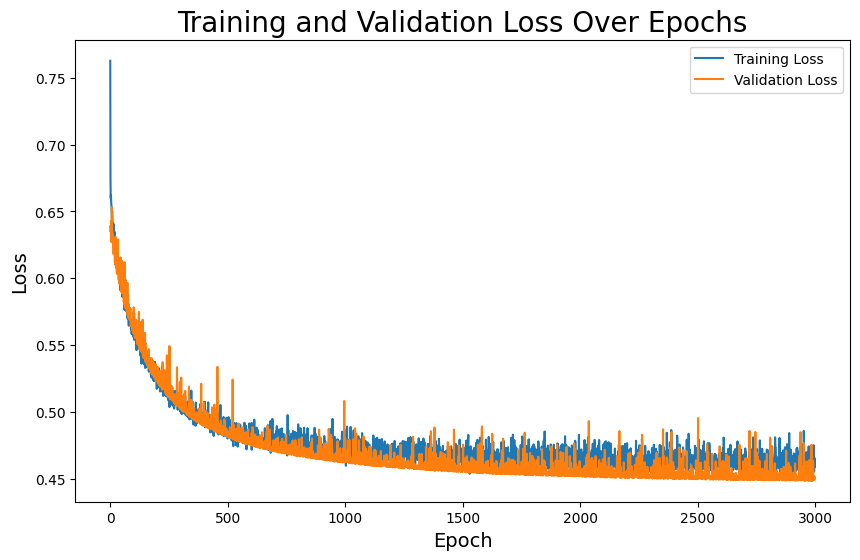

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_log, label='Training Loss')
plt.plot(val_loss_log, label='Validation Loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss Over Epochs', fontsize=20)
plt.legend()
plt.show()

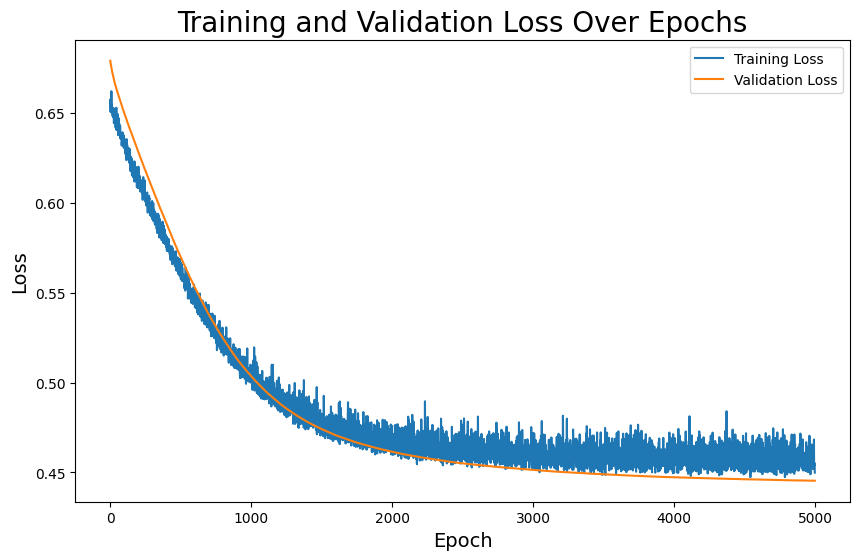

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_log, label='Training Loss')
plt.plot(val_loss_log, label='Validation Loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss Over Epochs', fontsize=20)
plt.legend()
plt.show()

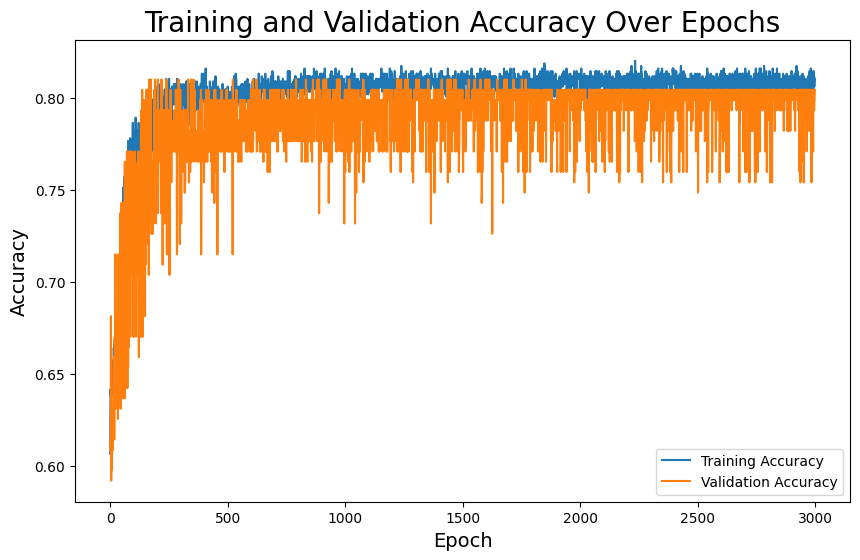

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy_log, label='Training Accuracy')
plt.plot(val_accuracy_log, label='Validation Accuracy')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy Over Epochs', fontsize=20)
plt.legend()
plt.show()

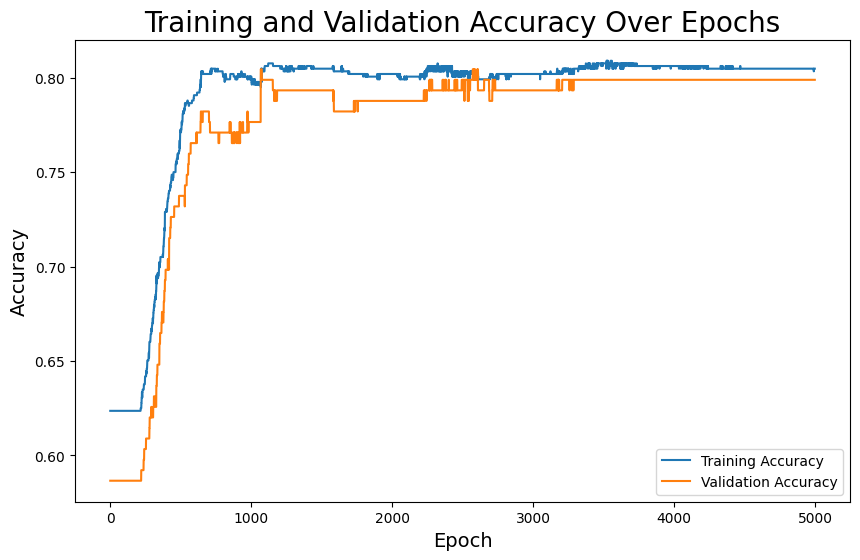

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy_log, label='Training Accuracy')
plt.plot(val_accuracy_log, label='Validation Accuracy')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy Over Epochs', fontsize=20)
plt.legend()
plt.show()

In [ ]:
# import numpy as np
# def moving_average(y, window_size):
#     return np.convolve(y, np.ones(window_size)/window_size, mode='valid')

In [ ]:

# # Prediction on the test set
# model.eval()
# test_predictions = []
# with torch.no_grad():
#     for X_batch, _ in test_loader:
#         y_pred = model(X_batch)
#         predictions = (y_pred > 0.5).int().flatten().tolist()
#         test_predictions.extend(predictions)

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
        nn.Linear(9,652),
        nn.Sigmoid(inplace=True),
        nn.Linear(652,780),
        nn.Sigmoid(inplace=True),
        nn.Linear(780, 908),
        nn.Sigmoid(inplace=True),
        nn.Linear(908, 1036),
        )

    def forward(self, x):
        x = self.generator(x)
        return x